# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель:** Построить модель, которая умеет определять рыночную стоимость автомобиля.
     
   Работа пройдёт в несколько этапов:
 1. Загрузка и подготовка данных.
 2. Обучение моделей.
 3. Анализ моделей.
 4. Общий вывод.

<font size="4">**Описание данных:**</font>     

**Признаки:**

+ DateCrawled — дата скачивания анкеты из базы
+ VehicleType — тип автомобильного кузова
+ RegistrationYear — год регистрации автомобиля
+ Gearbox — тип коробки передач
+ Power — мощность (л. с.)
+ Model — модель автомобиля
+ Kilometer — пробег (км)
+ RegistrationMonth — месяц регистрации автомобиля
+ FuelType — тип топлива
+ Brand — марка автомобиля
+ Repaired — была машина в ремонте или нет
+ DateCreated — дата создания анкеты
+ NumberOfPictures — количество фотографий автомобиля
+ PostalCode — почтовый индекс владельца анкеты (пользователя)
+ LastSeen — дата последней активности пользователя

**Целевой признак:**

+ Price — цена (евро)

In [1]:
!pip install skimpy

In [2]:
# подключаем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import phik

from skimpy import clean_columns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder 
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.simplefilter('ignore')

RANDOM_STATE = 123

## Подготовка данных

### Загрузка и анализ данных

In [3]:
# загрузим датасет
if os.path.exists('11.1. autos.csv'):
    data = pd.read_csv('11.1. autos.csv')
elif os.path.exists('/datasets/autos.csv'):
    data = pd.read_csv('/datasets/autos.csv')
else:
    print('Nothing works.')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df = data.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [7]:
# посмотрим на количество пропусков в процентах
df.isna().mean()*100

DateCrawled           0.000000
Price                 0.000000
VehicleType          10.579368
RegistrationYear      0.000000
Gearbox               5.596709
Power                 0.000000
Model                 5.560588
Kilometer             0.000000
RegistrationMonth     0.000000
FuelType              9.282697
Brand                 0.000000
Repaired             20.079070
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

In [8]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [9]:
df.describe(include=['object'])

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,Repaired,DateCreated,LastSeen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268251,29232,216352,77013,247161,13719,17


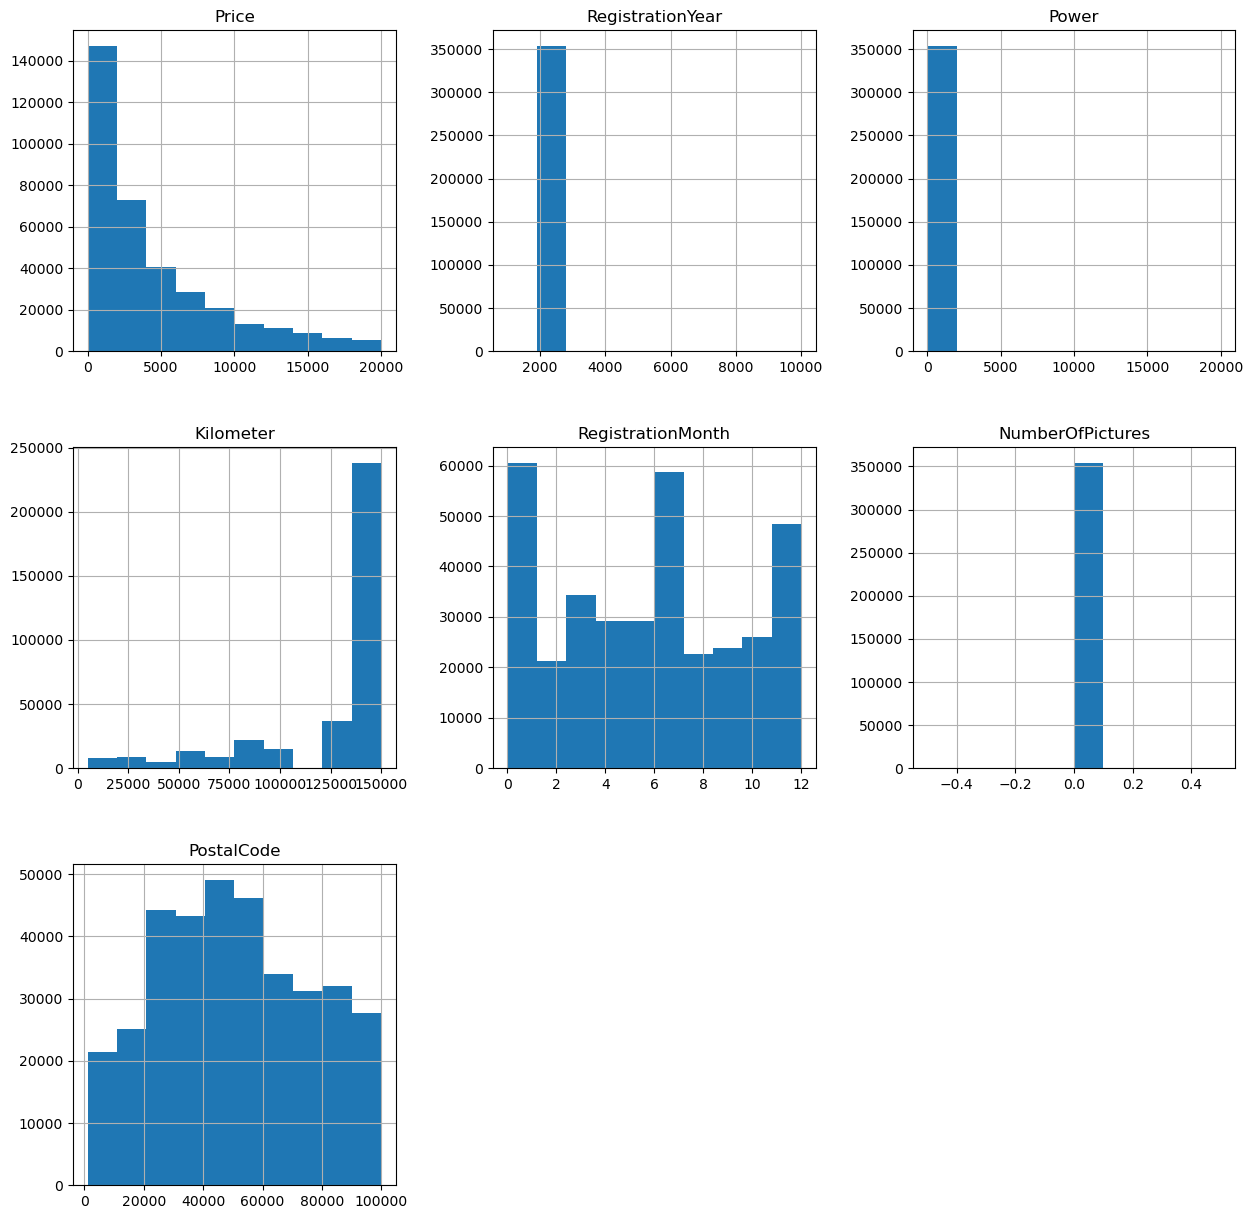

In [10]:
# строим гистограммы для всего датафрейма
df.hist(figsize=(15, 15))
plt.show()

In [11]:
# проверим дубликаты
df.duplicated().sum()

4

**Первоначальные выводы:**        
+ нужно привести названия колонок в snake-case.      
+ имеются пропуски в пяти колонках.
+ в некоторых колонках изменит тип на категориальный
+ присутствует небольшое количество дубликатов.     
+ также присутствуют аномальные значения, такие как нулевая цена или год регистрации ( min=1000, max=9999) или 20000 л.с. в "Power" (видимо вместе с авто продают самолёты).          
+ есть неинформативные колонки, например, "NumberOfPictures" заполнена нулями.

### Предобработка данных

#### Названия столбцов в snake-case

In [12]:
df = clean_columns(df)

In [13]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

#### Удалим дубликаты

In [14]:
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

#### Обработка аномалий

##### Столбец "price"

In [15]:
df.price.describe()

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

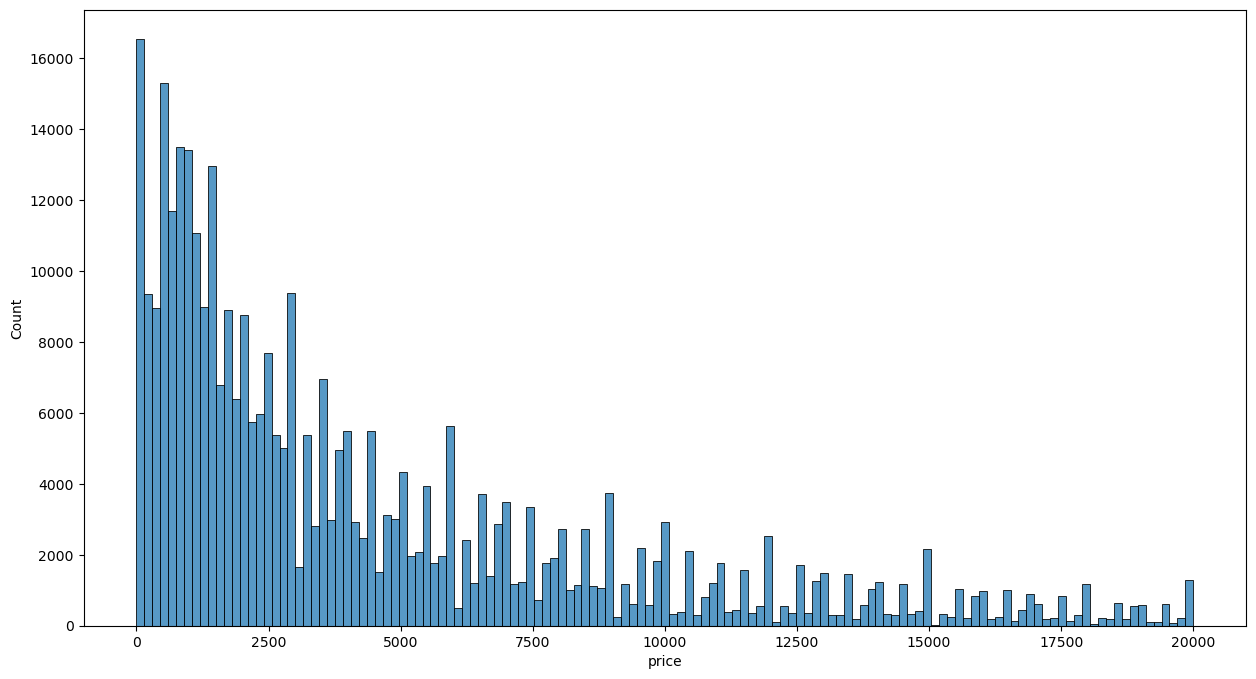

In [16]:
plt.figure(figsize=(15, 8))
sns.histplot(df.price)
plt.show()

In [17]:
# напишем функцию для расчёта минимального и максимального значений
def quant(col):
    q1 = df[col].quantile(.25)  # первый квартиль Q1
    q3 = df[col].quantile(.75)  # третий квартиль Q3
    iqr = q3 - q1                 # межквартильный размах IQR
    min_val = q1  - 1.5 * iqr
    max_val = q3  + 1.5 * iqr
    return min_val, max_val

In [18]:
quant('price')

(-6975.0, 14425.0)

**Возьмём минимальное значение 200 евро, и то эти машины уже только на запчасти.**

In [19]:
df.query('price < 200').price.value_counts().sort_index(ascending=True)

0      10772
1       1189
2         12
3          8
4          1
       ...  
193        1
195       12
196        1
198        3
199      276
Name: price, Length: 114, dtype: int64

In [20]:
df.query('price < 200')['price'].count()

17462

In [24]:
df = df[df.price > 200]

##### Столбец "registration_year"

In [25]:
df.registration_year.describe()

count    334917.000000
mean       2003.977920
std          67.384499
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

In [26]:
# посмотрим на "усы"
quant('registration_year')

(1985.5, 2021.5)

In [27]:
# и на максимальную дату создания
df.date_created.max()

'2016-04-07 00:00:00'

**Максимальный год регистрации 2016, т.е. строки со значениями выше мы удалим. И, хотя, левый "ус" на значении 1988 год, мы возьмём 1950 год. У ретро-авто, созданных раньше 1950, стоимость гораздо выше 20000)))**

In [28]:
# удалим аномальные значения
df = df[(df.registration_year > 1949) & (df.registration_year < 2017)]

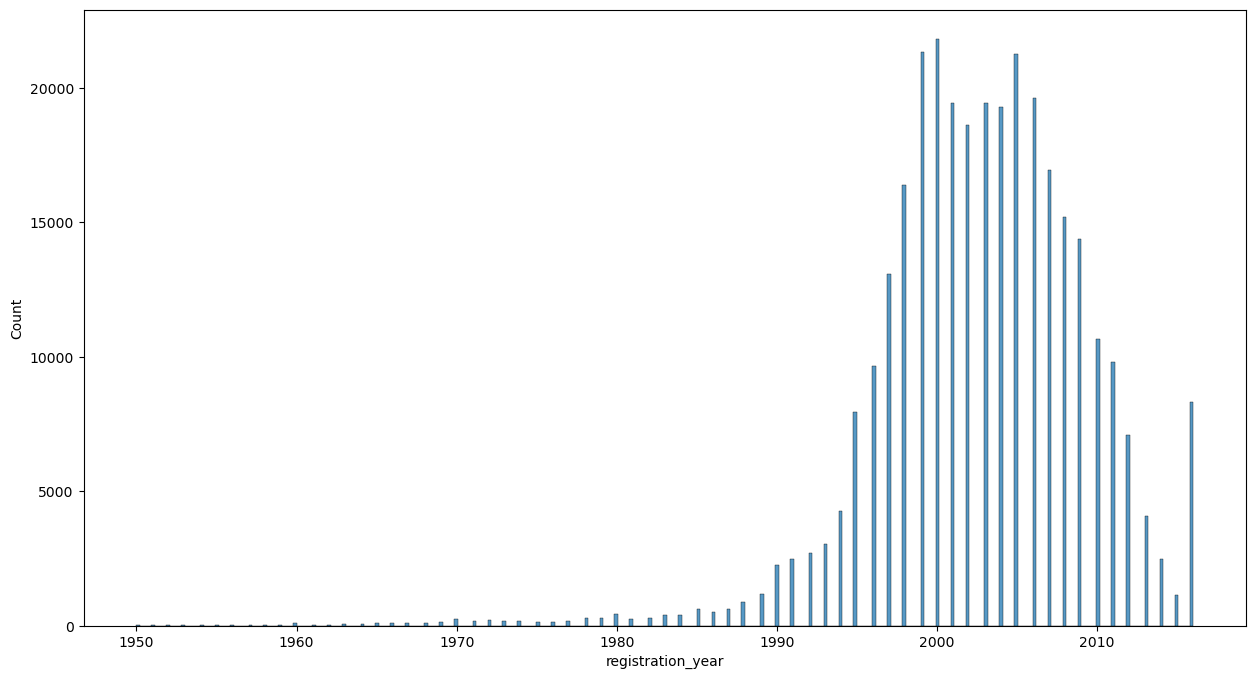

In [29]:
plt.figure(figsize=(15, 8))
sns.histplot(df.registration_year)
plt.show()

In [30]:
# на графике мы видим, что видимые значения начинаются с 1959
df = df[df.registration_year > 1958]

##### Столбец "power"

In [31]:
quant('power')

(-27.0, 245.0)

In [32]:
df.query('power > 6000')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
7661,2016-04-02 19:25:25,1499,small,1999,manual,7515,lupo,150000,4,petrol,volkswagen,NaN,2016-04-02 00:00:00,0,65830,2016-04-06 11:46:49
25232,2016-03-28 19:57:39,10900,bus,2009,manual,10520,caddy,150000,6,gasoline,volkswagen,no,2016-03-28 00:00:00,0,36272,2016-04-07 02:47:02
33952,2016-03-09 11:37:03,3740,small,2006,manual,6920,aygo,90000,10,NaN,toyota,no,2016-03-09 00:00:00,0,94116,2016-03-17 05:16:32
44520,2016-03-10 22:37:21,2500,convertible,1998,manual,7512,golf,150000,6,NaN,volkswagen,NaN,2016-03-10 00:00:00,0,68239,2016-04-05 15:17:50
45053,2016-04-07 07:36:38,15800,convertible,2014,auto,10218,fortwo,30000,3,petrol,smart,NaN,2016-04-06 00:00:00,0,81373,2016-04-07 07:36:38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328858,2016-03-20 09:57:28,850,small,2000,manual,8500,corsa,150000,3,petrol,opel,no,2016-03-20 00:00:00,0,26721,2016-04-04 05:50:15
339638,2016-03-07 16:58:44,600,sedan,2000,manual,10110,focus,125000,12,petrol,ford,NaN,2016-03-07 00:00:00,0,35066,2016-03-07 17:41:33
341316,2016-03-29 21:40:33,1899,other,2006,manual,7518,berlingo,125000,11,petrol,citroen,yes,2016-03-29 00:00:00,0,89428,2016-03-31 15:17:03
346635,2016-03-25 12:55:36,1300,sedan,2000,manual,12512,carisma,150000,9,petrol,mitsubishi,NaN,2016-03-25 00:00:00,0,42105,2016-04-06 14:44:53


In [33]:
df.query('model == "aygo" and registration_year == 2006')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
9243,2016-04-04 22:56:13,3400,small,2006,manual,68,aygo,90000,11,petrol,toyota,no,2016-04-04 00:00:00,0,65830,2016-04-05 12:30:20
16009,2016-04-03 23:37:42,1490,NaN,2006,manual,0,aygo,90000,9,petrol,toyota,yes,2016-04-03 00:00:00,0,66111,2016-04-04 06:41:28
24972,2016-04-02 12:27:39,2500,small,2006,manual,0,aygo,150000,0,petrol,toyota,NaN,2016-04-02 00:00:00,0,65931,2016-04-05 17:26:29
25235,2016-03-22 12:59:27,2700,small,2006,manual,68,aygo,125000,4,petrol,toyota,NaN,2016-03-22 00:00:00,0,66126,2016-04-04 01:16:07
26896,2016-03-24 13:56:31,3999,small,2006,manual,68,aygo,20000,3,petrol,toyota,no,2016-03-24 00:00:00,0,22523,2016-03-24 14:40:28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328285,2016-03-26 22:51:39,1950,small,2006,manual,68,aygo,125000,3,petrol,toyota,no,2016-03-26 00:00:00,0,67550,2016-03-26 22:51:39
335455,2016-03-09 19:36:18,3500,small,2006,manual,0,aygo,150000,0,petrol,toyota,no,2016-03-09 00:00:00,0,22045,2016-03-17 16:45:40
344676,2016-03-24 19:38:21,2499,small,2006,manual,68,aygo,125000,11,petrol,toyota,no,2016-03-24 00:00:00,0,90461,2016-04-05 11:17:18
346734,2016-03-12 19:58:27,2650,small,2006,manual,68,aygo,90000,5,petrol,toyota,no,2016-03-12 00:00:00,0,26603,2016-03-12 19:58:27


In [34]:
df.query('model == "aygo" and registration_year == 2006')['power'].value_counts()

68      50
0       10
69       5
50       2
6920     1
60       1
54       1
95       1
70       1
52       1
92       1
Name: power, dtype: int64

**Если посмотреть на данные выше, можно понять, что значения выше 6_000 мы можем поделить на 100.**

In [35]:
df.power = df.power.apply(lambda x: x // 100 if x > 6000 else x)

In [36]:
df.query('model == "aygo" and registration_year == 2006')['power'].value_counts()

68    50
0     10
69     6
50     2
60     1
54     1
95     1
70     1
52     1
92     1
Name: power, dtype: int64

**По той же аналогии заполним значения больше 600.**

In [37]:
df.power = df.power.apply(lambda x: x // 10 if x > 600 else x)

In [38]:
df.power.describe()

count    321085.000000
mean        110.168298
std          62.171029
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max         600.000000
Name: power, dtype: float64

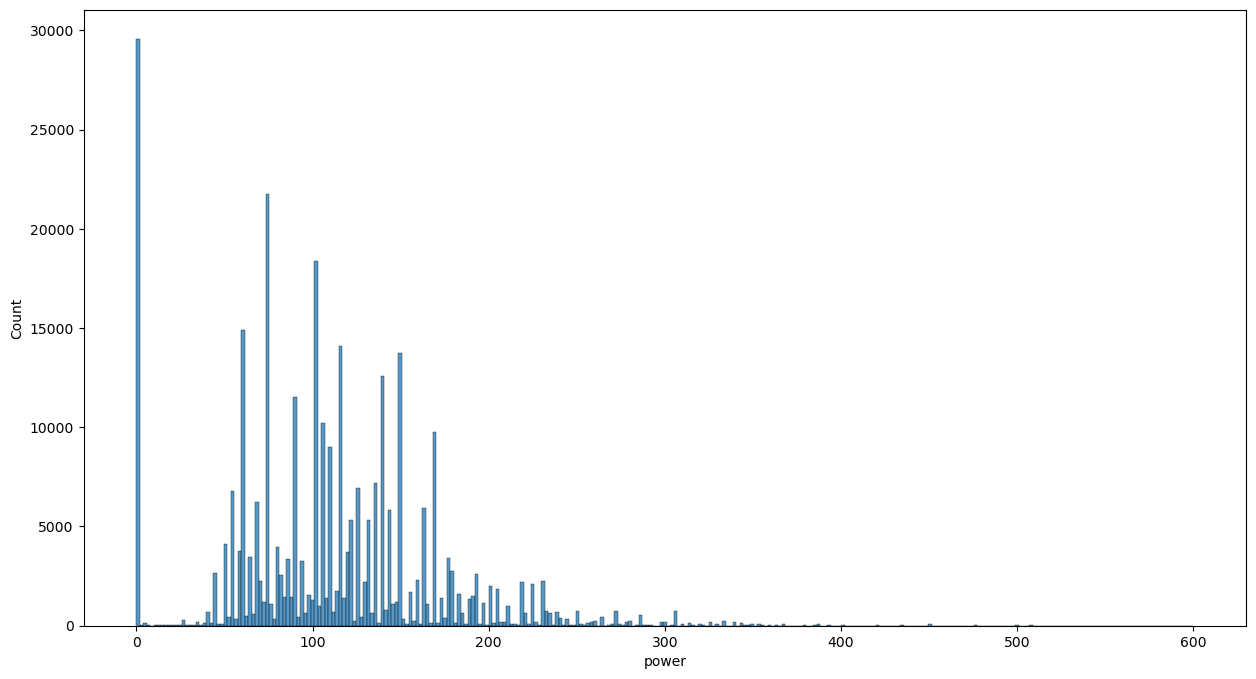

In [39]:
plt.figure(figsize=(15, 8))
sns.histplot(df.power)
plt.show()

**Мы видим довольно много нулевых значений. Заполним значения менее 5 NaN-ом, а затем заполним медианой, сгруппировав по модели и году.**

In [40]:
df.query('model == "aygo" and registration_year == 2006')['power'].value_counts()

68    50
0     10
69     6
50     2
60     1
54     1
95     1
70     1
52     1
92     1
Name: power, dtype: int64

In [41]:
df.loc[df['power'] < 5, 'power'] = np.nan

In [42]:
df.power.fillna(df.groupby(['model', 'registration_year'])['power'].transform('median'), inplace=True)

In [43]:
df.query('model == "aygo" and registration_year == 2006')['power'].value_counts()

68.0    60
69.0     6
50.0     2
60.0     1
54.0     1
95.0     1
70.0     1
52.0     1
92.0     1
Name: power, dtype: int64

In [44]:
df.power.isna().sum()

3948

In [45]:
# остальные строки удалим
df = df.dropna(subset=['power']).reset_index(drop=True)
df.power.isna().sum()

0

In [46]:
df.power = df.power.astype(int)

**Столбец пробега не вызывает подозрений)**

#### Обработка пропусков

##### Столбец "model"

In [47]:
df.isna().mean()*100

date_crawled           0.000000
price                  0.000000
vehicle_type           4.896937
registration_year      0.000000
gearbox                3.758313
power                  0.000000
model                  3.370783
kilometer              0.000000
registration_month     0.000000
fuel_type              6.205835
brand                  0.000000
repaired              16.756796
date_created           0.000000
number_of_pictures     0.000000
postal_code            0.000000
last_seen              0.000000
dtype: float64

In [48]:
df[df.model == 'other'].head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
21,2016-03-13 20:40:49,500,sedan,1990,manual,118,other,150000,10,petrol,mercedes_benz,yes,2016-03-13 00:00:00,0,35390,2016-03-13 20:40:49
34,2016-04-01 17:45:07,11900,other,2002,manual,129,other,150000,11,gasoline,volkswagen,no,2016-04-01 00:00:00,0,10551,2016-04-05 12:47:30
35,2016-03-25 15:50:30,1500,bus,1984,manual,70,other,150000,8,gasoline,mercedes_benz,no,2016-03-25 00:00:00,0,22767,2016-03-27 03:17:02
45,2016-04-04 10:57:36,1400,NaN,2016,manual,55,other,5000,1,NaN,hyundai,NaN,2016-04-04 00:00:00,0,34454,2016-04-06 12:45:43
56,2016-03-21 12:47:55,2100,suv,2000,manual,105,other,150000,8,petrol,honda,no,2016-02-09 00:00:00,0,85244,2016-03-31 16:46:09


In [49]:
df.query('brand == "mercedes_benz" and vehicle_type == "sedan" and power == 118')['model'].value_counts()

other       109
e_klasse     40
c_klasse      3
s_klasse      1
glk           1
Name: model, dtype: int64

In [50]:
df[df.model == 'other']['model'].count()

22499

**Так как заполнить пропуски в колонке "model" не представляется возможным, даже если сопоставить все колонки, заполним их значением "unknown".**

In [51]:
df.model = df.model.fillna('unknown')
df.model.isna().sum()

0

##### Столбец "repaired"

**С пропусками в колонке "repaired" поступим также, как и с балконами в проекте о продаже квартир. Можем предположить, что если не указано, был ремонт или нет, то, скорее всего, ремонт не производился. Поэтому заполним пропуски значением "no".**

In [52]:
df.repaired = df.repaired.fillna('no')
df.repaired.isna().sum()

0

##### Столбец "vehicle_type"

In [53]:
df.vehicle_type.value_counts()

sedan          87691
small          74164
wagon          62557
bus            27969
convertible    19613
coupe          15223
suv            11597
other           2793
Name: vehicle_type, dtype: int64

In [54]:
df.vehicle_type.isna().sum()

15530

In [55]:
df[df.vehicle_type.isna()].head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,90,golf,150000,0,petrol,volkswagen,no,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
14,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,no,2016-04-01 00:00:00,0,38871,2016-04-01 12:46:46
27,2016-03-29 16:57:02,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,no,2016-03-29 00:00:00,0,37075,2016-03-29 17:43:07
31,2016-03-08 07:54:46,350,NaN,2016,manual,75,golf,150000,4,petrol,volkswagen,no,2016-03-08 00:00:00,0,19386,2016-03-08 09:44:50
33,2016-03-28 17:50:15,1500,NaN,2016,NaN,75,kangoo,150000,1,gasoline,renault,no,2016-03-28 00:00:00,0,46483,2016-03-30 09:18:02


In [56]:
df.query('model == "polo" and registration_year == 2016')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
14,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,no,2016-04-01 00:00:00,0,38871,2016-04-01 12:46:46
694,2016-03-24 18:38:59,3500,NaN,2016,manual,64,polo,100000,9,petrol,volkswagen,no,2016-03-24 00:00:00,0,52353,2016-04-01 15:15:33
832,2016-03-24 14:46:18,2000,NaN,2016,manual,59,polo,100000,0,petrol,volkswagen,yes,2016-03-24 00:00:00,0,22047,2016-03-24 14:46:18
2073,2016-04-03 13:29:42,399,NaN,2016,manual,60,polo,150000,0,petrol,volkswagen,yes,2016-04-03 00:00:00,0,35510,2016-04-03 13:49:40
2450,2016-03-16 20:56:25,1100,NaN,2016,manual,60,polo,150000,0,NaN,volkswagen,no,2016-03-16 00:00:00,0,31789,2016-04-07 07:46:15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311083,2016-03-27 17:52:33,250,NaN,2016,manual,60,polo,150000,0,NaN,volkswagen,no,2016-03-27 00:00:00,0,34537,2016-04-05 14:16:16
311148,2016-03-26 10:38:02,275,NaN,2016,manual,60,polo,150000,0,petrol,volkswagen,no,2016-03-26 00:00:00,0,19069,2016-04-03 20:44:28
312147,2016-03-23 13:49:09,4000,NaN,2016,manual,60,polo,100000,0,petrol,volkswagen,no,2016-03-23 00:00:00,0,18337,2016-04-05 14:17:33
314210,2016-03-09 22:51:06,5350,NaN,2016,NaN,60,polo,80000,9,petrol,volkswagen,no,2016-03-09 00:00:00,0,61191,2016-03-19 23:44:31


In [57]:
df.query('model == "kangoo" and registration_year == 2016')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
33,2016-03-28 17:50:15,1500,NaN,2016,NaN,75,kangoo,150000,1,gasoline,renault,no,2016-03-28 00:00:00,0,46483,2016-03-30 09:18:02
614,2016-03-30 11:48:53,400,NaN,2016,manual,75,kangoo,150000,0,gasoline,renault,yes,2016-03-30 00:00:00,0,70629,2016-04-03 01:21:16
5010,2016-04-04 13:39:36,1200,NaN,2016,NaN,75,kangoo,150000,0,gasoline,renault,no,2016-04-04 00:00:00,0,30539,2016-04-04 13:39:36
6387,2016-03-29 19:43:14,300,NaN,2016,manual,75,kangoo,150000,3,NaN,renault,yes,2016-03-29 00:00:00,0,24148,2016-03-29 19:43:14
19726,2016-03-12 09:47:48,1150,NaN,2016,manual,75,kangoo,125000,3,NaN,renault,no,2016-03-12 00:00:00,0,31020,2016-03-17 06:18:10
67278,2016-03-30 23:55:13,650,NaN,2016,NaN,75,kangoo,150000,0,NaN,renault,no,2016-03-30 00:00:00,0,58791,2016-04-05 15:15:54
73685,2016-03-31 17:48:41,750,NaN,2016,manual,75,kangoo,150000,0,petrol,renault,no,2016-03-31 00:00:00,0,17235,2016-04-06 11:17:56
100905,2016-03-22 12:47:06,400,NaN,2016,manual,60,kangoo,150000,0,petrol,renault,no,2016-03-22 00:00:00,0,66280,2016-04-04 00:16:46
102831,2016-03-24 16:48:14,1500,NaN,2016,NaN,75,kangoo,150000,1,NaN,renault,no,2016-03-24 00:00:00,0,46483,2016-03-24 16:48:14
118983,2016-03-28 12:37:38,550,NaN,2016,manual,60,kangoo,150000,0,petrol,renault,no,2016-03-28 00:00:00,0,66280,2016-04-04 09:17:41


**Пропущенные значения мы заполним модой, также сгруппировав по модели и году. Хотя, не всё так радужно) В примере выше пропущены все значения в "моделе". Оставшиеся заполним "unknown".**

In [58]:
 df.vehicle_type = df.groupby(['model', 'registration_year'])['vehicle_type']\
                    .transform(lambda x: x.fillna(x.mode()[0] if x.count() != 0 else 'unknown'))

In [59]:
df.vehicle_type.isna().sum()

0

In [60]:
df.query('vehicle_type == "unknown"')['vehicle_type'].count()

2976

##### Столбец "gearbox"

In [61]:
df.gearbox.value_counts()

manual    243190
auto       62028
Name: gearbox, dtype: int64

In [62]:
df.gearbox.isna().sum()

11919

**Пропуски заполним по аналогии с предыдущим столбцом.**

In [63]:
 df.gearbox = df.groupby(['model', 'registration_year'])['gearbox']\
                    .transform(lambda x: x.fillna(x.mode()[0] if x.count() != 0 else 'unknown'))

In [64]:
df.query('gearbox == "unknown"')['gearbox'].count()

18

In [65]:
df.gearbox.value_counts()

manual     253631
auto        63488
unknown        18
Name: gearbox, dtype: int64

**Оставшиеся заполним модой.**

In [66]:
df.gearbox = df.gearbox.replace({'unknown': 'manual'})

In [67]:
df.gearbox.value_counts()

manual    253649
auto       63488
Name: gearbox, dtype: int64

##### Столбец "fuel_type"

In [68]:
df.fuel_type.value_counts()

petrol      197613
gasoline     93959
lpg           4953
cng            523
hybrid         218
other          117
electric        73
Name: fuel_type, dtype: int64

In [69]:
df.fuel_type.isna().sum()

19681

In [70]:
df.loc[df['fuel_type'] == 'gasoline', 'fuel_type'] = 'petrol'

In [71]:
 df.fuel_type = df.groupby(['model', 'registration_year'])['fuel_type']\
                    .transform(lambda x: x.fillna(x.mode()[0] if x.count() != 0 else 'unknown'))

In [72]:
df.query('fuel_type == "unknown"')['fuel_type'].count()

49

In [73]:
df.fuel_type = df.fuel_type.replace({'unknown': 'petrol'})

In [74]:
df.fuel_type.value_counts()

petrol      311223
lpg           4971
cng            524
hybrid         220
other          126
electric        73
Name: fuel_type, dtype: int64

#### Категоризируем столбец "registration_year".

In [75]:
def categorize_years(year):
    if 1959 <= year <= 1970:
        return 'супер-ретро'
    if year <= 1980:
        return 'ретро'
    if year <= 1990:
        return 'очень старая'
    if year <= 2000:
        return 'старая'
    if year <= 2010:
        return 'подержанная'
    return 'новая'

In [76]:
# добавляем столбец, используя метод apply и собственную функцию
df['category_years'] = df['registration_year'].apply(categorize_years)

In [77]:
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen,category_years
0,2016-03-24 11:52:17,480,sedan,1993,manual,90,golf,150000,0,petrol,volkswagen,no,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57,старая
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknown,125000,5,petrol,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50,новая
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,no,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46,подержанная
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17,подержанная
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,petrol,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21,подержанная


#### Удаление неинформативных колонок.

In [78]:
df.head(1)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen,category_years
0,2016-03-24 11:52:17,480,sedan,1993,manual,90,golf,150000,0,petrol,volkswagen,no,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57,старая


**На мой взгляд малоинформативные колонки - это три колонки с датами, месяц регистрации и колонка с нулевым количеством фотографий.**

In [79]:
df = df.drop(['date_crawled', 'registration_month', 'date_created', 'number_of_pictures', 'last_seen'], axis=1)

In [80]:
df.head(1)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,postal_code,category_years
0,480,sedan,1993,manual,90,golf,150000,petrol,volkswagen,no,70435,старая


#### Изменение типа

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317137 entries, 0 to 317136
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              317137 non-null  int64 
 1   vehicle_type       317137 non-null  object
 2   registration_year  317137 non-null  int64 
 3   gearbox            317137 non-null  object
 4   power              317137 non-null  int32 
 5   model              317137 non-null  object
 6   kilometer          317137 non-null  int64 
 7   fuel_type          317137 non-null  object
 8   brand              317137 non-null  object
 9   repaired           317137 non-null  object
 10  postal_code        317137 non-null  int64 
 11  category_years     317137 non-null  object
dtypes: int32(1), int64(4), object(7)
memory usage: 27.8+ MB


In [82]:
categ = list(df.select_dtypes(include=['object']).columns)
categ

['vehicle_type',
 'gearbox',
 'model',
 'fuel_type',
 'brand',
 'repaired',
 'category_years']

In [83]:
df[categ] = df[categ].astype('category')

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317137 entries, 0 to 317136
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              317137 non-null  int64   
 1   vehicle_type       317137 non-null  category
 2   registration_year  317137 non-null  int64   
 3   gearbox            317137 non-null  category
 4   power              317137 non-null  int32   
 5   model              317137 non-null  category
 6   kilometer          317137 non-null  int64   
 7   fuel_type          317137 non-null  category
 8   brand              317137 non-null  category
 9   repaired           317137 non-null  category
 10  postal_code        317137 non-null  int64   
 11  category_years     317137 non-null  category
dtypes: category(7), int32(1), int64(4)
memory usage: 13.3 MB


**Посмотрим на получившиеся признаки.**

interval columns not set, guessing: ['price', 'registration_year', 'power', 'kilometer', 'postal_code']


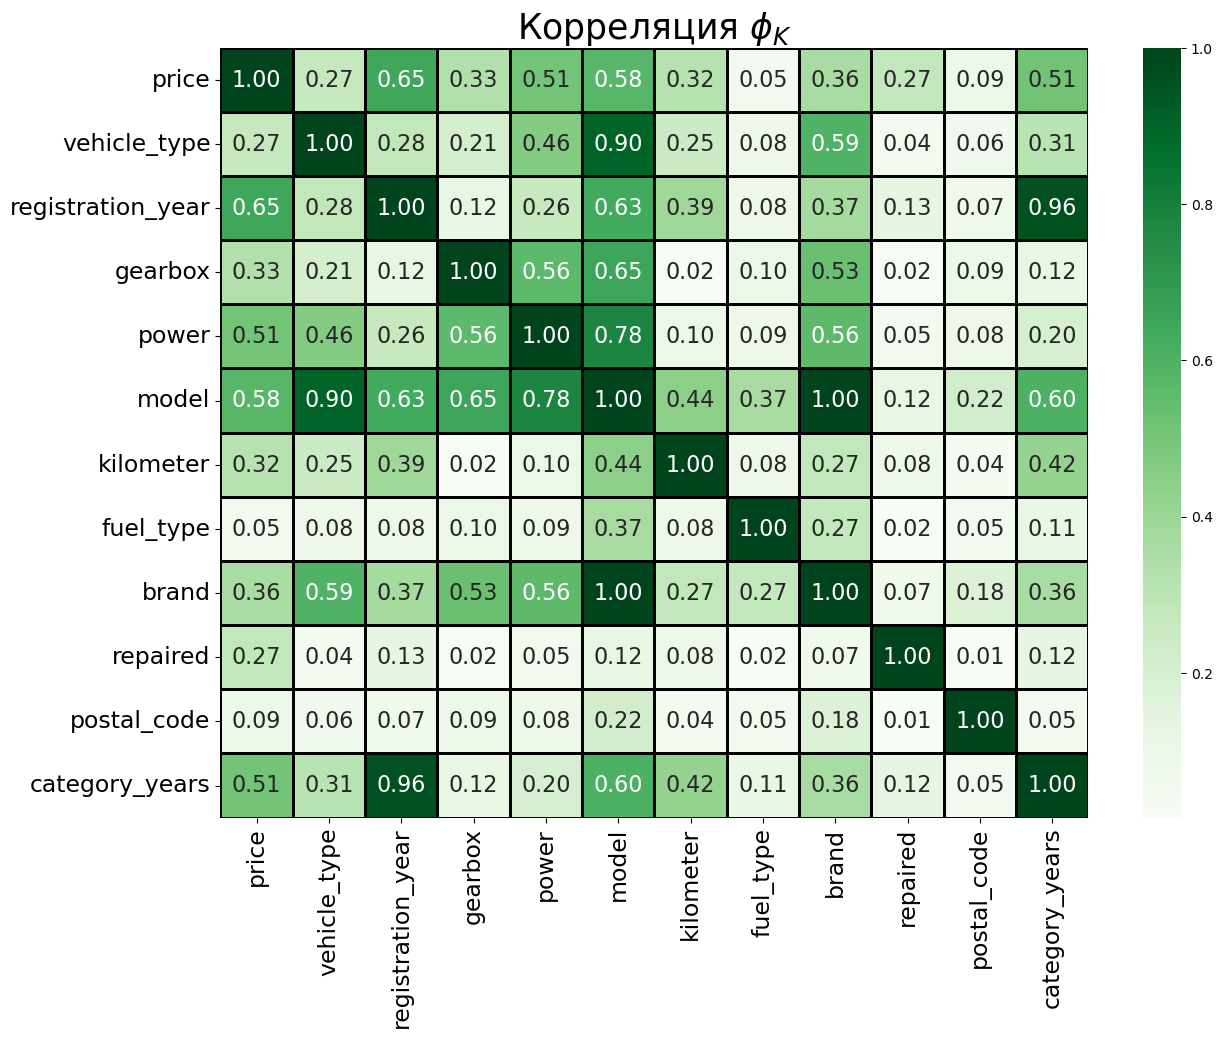

Wall time: 5.85 s


In [85]:
%%time
plt.figure(figsize = (14, 10))
ax = plt.axes()
sns.heatmap(df.phik_matrix(),
            annot=True,
            annot_kws={'size':16},
            fmt='.2f',
            cmap='Greens',
            linewidths=2,
            linecolor='black')
plt.title(r'Корреляция $\phi_K$', fontsize=25)
plt.tick_params(labelsize=17) 
plt.show()

interval columns not set, guessing: ['price', 'registration_year', 'power', 'kilometer', 'postal_code']


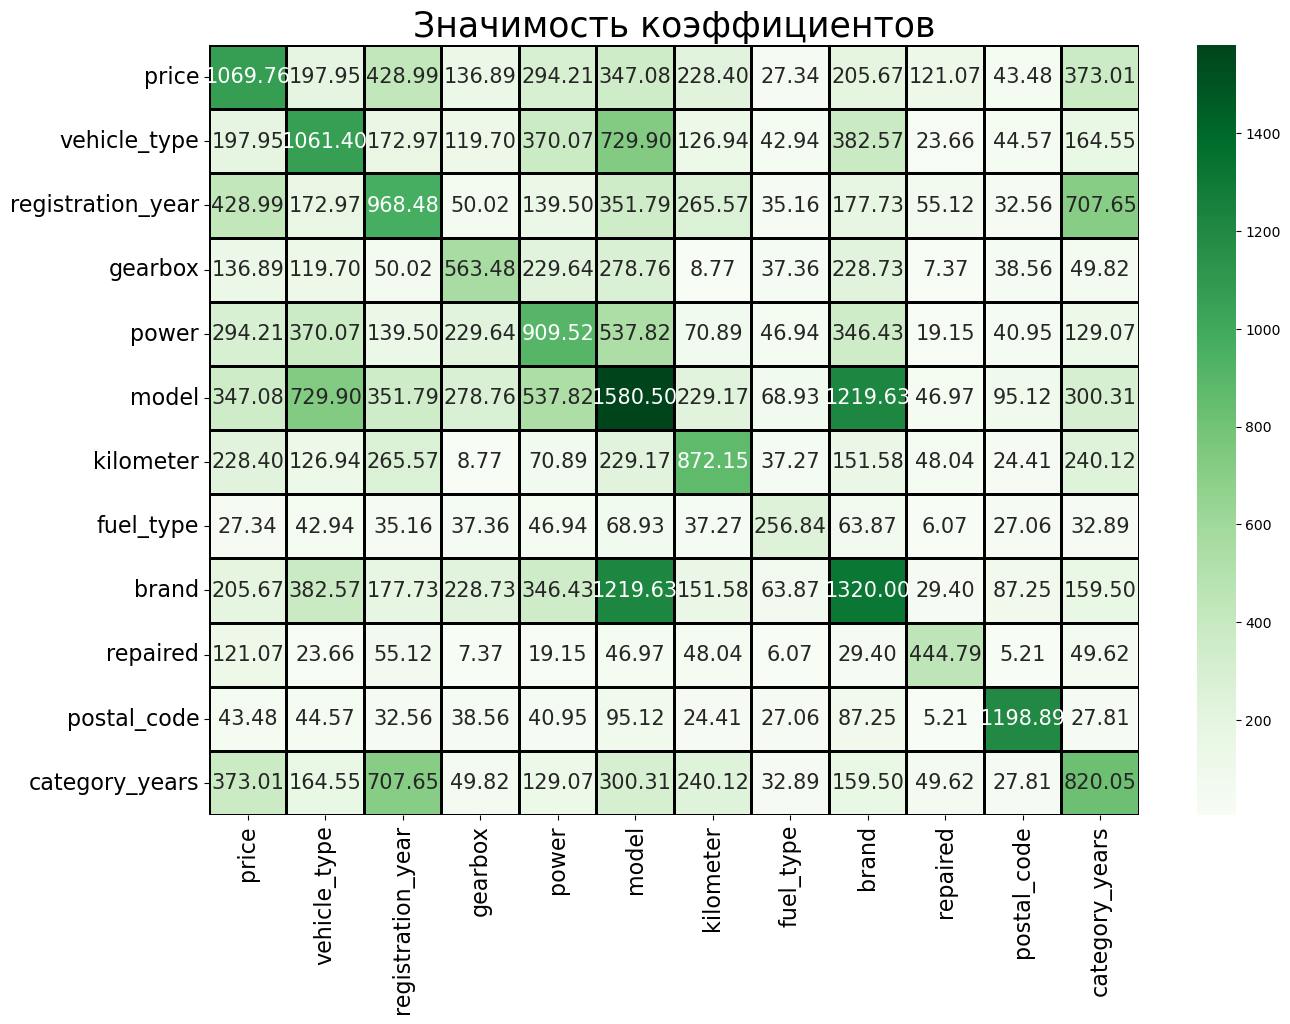

Wall time: 21 s


In [86]:
%%time
plt.figure(figsize = (15, 10))
sns.heatmap(df.significance_matrix(),
            annot=True,
            annot_kws={'size': 15},
            fmt='.2f',
            cmap='Greens',
            linewidths=2,
            linecolor='black')
plt.tick_params(labelsize=16) 
plt.title(r'Значимость коэффициентов', fontsize=25)
plt.show()

**Если верить коэффициентам, то стоимость авто в первую очередь зависит от года выпуска, затем от модели, затем от мощности.**

**Вывод:**      
+ привели названия колонок в snake-case.      
+ заполнили пропуски.
+ в некоторых колонках изменили тип
+ удалили дубликаты.     
+ оьработали аномальные значения        
+ удалили неинформативные колонки.

## Обучение моделей

### Разобьём данные на выборки

In [87]:
# создадим scorer для RMSE
def rmse(y, pred):
    return  mean_squared_error(y, pred, squared = False)
RMSE_scorer = make_scorer(rmse, greater_is_better=False)

**Разобьём на три части: обучающую, валидационную и тестовую. Размеры тестового и валидационного наборов обычно равны. Исходные данные разобьём в соотношении 3:1:1.**

In [88]:
# разобьём данные на признаки и целевой признак
X = df.drop(['price'], axis=1)
y = df['price']

In [89]:
X.shape, y.shape

((317137, 11), (317137,))

In [90]:
# разобьём сначала на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=RANDOM_STATE, shuffle=True)

In [91]:
# затем разобьём на тестовый и валидационный наборы
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE)

In [92]:
# проверим длины наших выборок
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((190282, 11), (190282,), (63427, 11), (63427,), (63428, 11), (63428,))

In [93]:
numeric = ['registration_year', 'power', 'kilometer', 'postal_code']
numeric

['registration_year', 'power', 'kilometer', 'postal_code']

### Линейная регрессия

**Сначала преобразуем категориальные признаки в численные с помощью One-Hot Encoding**

In [94]:
ohe = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = X_train.copy()
X_train_ohe = X_train_ohe.drop(['model'], axis=1)

# удалил model, так как при разбитии на выборки не все модели попали в обе выборки
# и как следствие, в X_train - 303 столбца, а в X_val 295

cat_ohe = ['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired', 'category_years']
X_train_ohe_categ = pd.DataFrame(ohe.fit_transform(X_train_ohe[cat_ohe]))
X_train_ohe_categ.index = X_train_ohe.index
X_train_ohe_categ.columns = ohe.get_feature_names()
X_train_ohe = X_train_ohe[numeric].join(X_train_ohe_categ)

In [95]:
%%time
model_LR = LinearRegression()
model_LR.fit(X_train_ohe, y_train)
RMSE = -cross_val_score(model_LR, X_train_ohe, y_train, cv=5, scoring=RMSE_scorer).mean()
print(f'Лучшее значение RMSE для линейной регрессии: {RMSE:.6f}')

Лучшее значение RMSE для линейной регрессии: 2581.931609
Wall time: 6.03 s


**Масштабирование ничего не меняет.**

### ElasticNet

In [96]:
%%time
grid_par_EN = {'l1_ratio': [0.9, 1],
               'alpha': [0.05, 0.1]}
model_EN = ElasticNet(random_state=RANDOM_STATE)
cv_EN = GridSearchCV(model_EN, grid_par_EN, scoring=RMSE_scorer, n_jobs=-1)
cv_EN.fit(X_train_ohe, y_train)
print(f'Лучший параметр: {cv_EN.best_params_}\nЛучший показатель RMSE для ElasticNet: {-cv_EN.best_score_:.6f}')

Лучший параметр: {'alpha': 0.05, 'l1_ratio': 1}       
Лучший показатель RMSE для ElasticNet: 2581.821038         
CPU times: user 12min 31s, sys: 31min 35s, total: 44min 6s         
Wall time: 44min 10s

### Дерево решений

**Преобразуем категориальные признаки в численные с помощью порядкоого кодирования.**

In [97]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_ordinal = pd.DataFrame(encoder.fit_transform(X_train), columns=X_train.columns) 
X_val_ordinal = pd.DataFrame(encoder.transform(X_val), columns=X_val.columns) 

In [98]:
%%time
grid_par_DT = {'max_depth': range(10, 16)}
model_DT = DecisionTreeRegressor(random_state=RANDOM_STATE)
cv_DT = GridSearchCV(model_DT, grid_par_DT, scoring=RMSE_scorer)
cv_DT.fit(X_train_ordinal, y_train)
print(f'Лучший параметр: {cv_DT.best_params_}\nЛучший показатель RMSE: {-cv_DT.best_score_:.6f}')

Лучший параметр: {'max_depth': 13}
Лучший показатель RMSE: 1957.290128
Wall time: 17.8 s


### Случайный лес

In [99]:
%%time
grid_par_RF = {'max_depth': [20, 22], 
              'n_estimators': [150, 200]}
model_RF = RandomForestRegressor(random_state=RANDOM_STATE)
cv_RF = GridSearchCV(model_RF, grid_par_RF, scoring=RMSE_scorer, n_jobs=-1)
cv_RF.fit(X_train_ordinal, y_train)
print(f'Лучший параметр: {cv_RF.best_params_}\nЛучший показатель RMSE: {-cv_RF.best_score_:.6f}')

Лучший параметр: {'max_depth': 20, 'n_estimators': 200}    
Лучший показатель RMSE: 1653.059939   
CPU times: user 41min 52s, sys: 14.4 s, total: 42min 6s     
Wall time: 42min 41s

### CatBoost

In [100]:
%%time
grid_par_CB = {'depth': [16, 18, 20],
               'learning_rate': [0.05, 0.1, 0.2],
               'iterations': [200, 300, 400]}
model_CB = CatBoostRegressor(random_state=RANDOM_STATE, cat_features=categ)
cv_CB = GridSearchCV(model_CB, grid_par_CB, scoring=RMSE_scorer)
cv_CB.fit(X_train, y_train, verbose=5)
print(f'Лучший параметр: {cv_CB.best_params_}\nЛучший показатель RMSE: {-cv_CB.best_score_:.6f}')

Лучший параметр: {'depth': 16, 'iterations': 400, 'learning_rate': 0.1}             
Лучший показатель RMSE: 1603.774078    
Wall time: 13h 12min 20s  

### LightGBM

In [101]:
%%time
grid_par_LGBM = {'max_depth': [20, 22],
                'n_estimators': [250, 260],
                'num_leaves': [350, 360]}
model_LGBM = LGBMRegressor(random_state=RANDOM_STATE)
cv_LGBM = GridSearchCV(model_LGBM, grid_par_LGBM, scoring=RMSE_scorer, n_jobs=-1)
cv_LGBM.fit(X_train, y_train, verbose=5)
print(f'Лучший параметр: {cv_LGBM.best_params_}\nЛучший показатель RMSE: {-cv_LGBM.best_score_:.6f}')

Лучший параметр: {'max_depth': 20, 'n_estimators': 260, 'num_leaves': 350}   
Лучший показатель RMSE: 1568.706644    
Wall time: 2min 15s

**Вывод:**     
Мы обучили и подобрали гиперпараметры для шести моделей:    
+ линейную классическую   
+ линейную с комбинацией L1 и L2 регуляризации
+ модель деревьев    
+ ансамбль деревьев     
+ две модели градиентного бустинга

## Анализ моделей

**Проанализируем модели на валидационной выборке и выберем лучшую.**

In [102]:
plt.style.use('fivethirtyeight')

### Линейная регрессия

In [103]:
X_val_ohe = X_val.copy()
X_val_ohe_categ = pd.DataFrame(ohe.transform(X_val_ohe[cat_ohe]))
X_val_ohe_categ.index = X_val_ohe.index
X_val_ohe_categ.columns = ohe.get_feature_names()
X_val_ohe = X_val_ohe[numeric].join(X_val_ohe_categ)

In [104]:
%%time
model_LR = LinearRegression()
model_LR.fit(X_train_ohe, y_train)

Wall time: 662 ms


LinearRegression()

In [105]:
%%time
pred_LR_val = model_LR.predict(X_val_ohe)
print(f'Лучшее значение RMSE для линейной регрессии: {rmse(y_val, pred_LR_val):.6f}')

Лучшее значение RMSE для линейной регрессии: 2569.064936
Wall time: 75 ms


In [106]:
res_LR =  ['Линейная регрессия', '2.54 s', '137 ms', 2569.064936]

### ElasticNet

In [107]:
%%time
model_EN = ElasticNet(random_state=RANDOM_STATE,
                      alpha=0.05,
                      l1_ratio=1)
model_EN.fit(X_train_ohe, y_train)

Wall time: 24min 30s


ElasticNet(alpha=0.05, l1_ratio=1, random_state=123)

In [108]:
%%time
pred_EN_val = model_EN.predict(X_val_ohe)
print(f'Лучший показатель RMSE: {rmse(y_val, pred_EN_val):.6f}')

Лучший показатель RMSE: 2568.965994
Wall time: 42.2 ms


In [109]:
res_EN = ['ElasticNet', '58.8 s', '116 ms', 2568.965994]

### Дерево решений

In [110]:
%%time
model_DT = DecisionTreeRegressor(random_state=RANDOM_STATE,
                                 max_depth=13)
model_DT.fit(X_train_ordinal, y_train)

Wall time: 745 ms


DecisionTreeRegressor(max_depth=13, random_state=123)

In [111]:
%%time
pred_DT_val = model_DT.predict(X_val_ordinal)
print(f'Лучший показатель RMSE: {rmse(y_val, pred_DT_val):.6f}')

Лучший показатель RMSE: 1924.850968
Wall time: 15 ms


In [112]:
res_DT = ['Дерево решений', '799 ms', '14.6 ms', 1924.850968]

In [113]:
X_imp_DT = pd.DataFrame({'features':X_train_ordinal.columns,'feature_importance':model_DT.feature_importances_})
X_imp_DT = X_imp_DT.set_index('features')
X_imp_DT.sort_values('feature_importance',ascending=False)

,feature_importance
features,
registration_year,0.541370
power,0.285625
kilometer,0.051249
brand,0.028455
vehicle_type,0.026804
category_years,0.024050
model,0.017593
repaired,0.011105
postal_code,0.010086


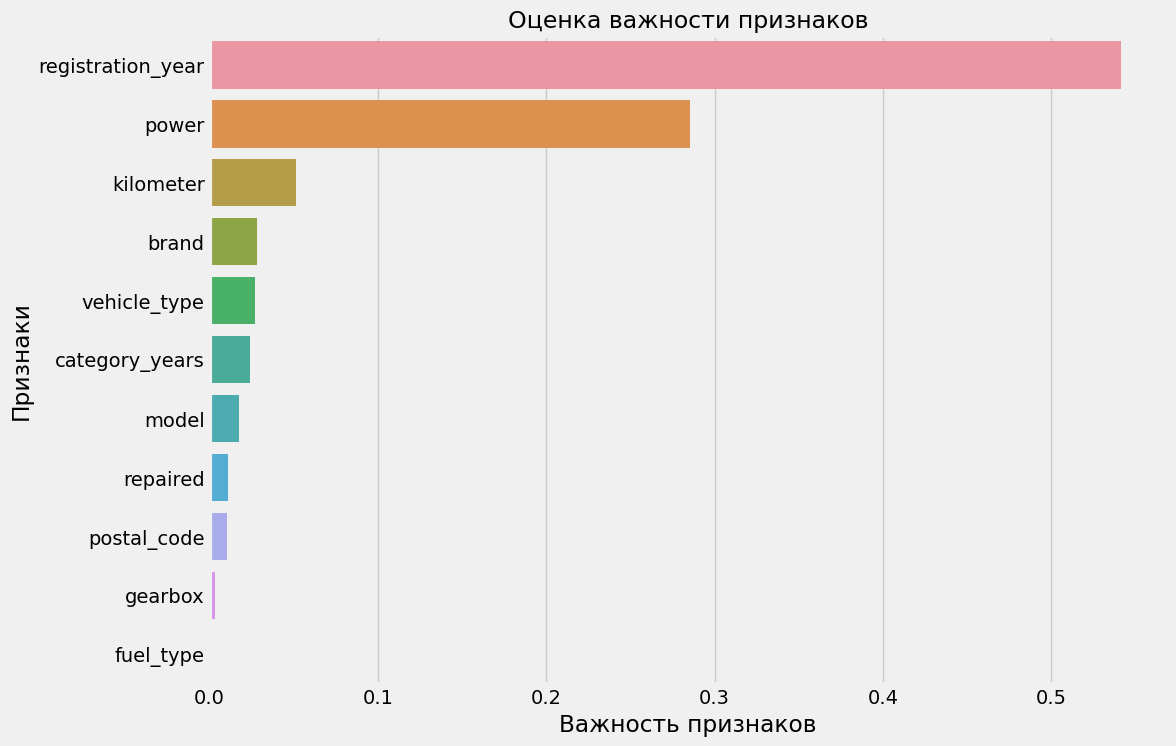

In [114]:
plt.figure(figsize=(11, 8))
sns.barplot(x=X_imp_DT['feature_importance'], y=X_imp_DT.index, order=X_imp_DT\
                .sort_values('feature_importance', ascending=False).index)
plt.title('Оценка важности признаков', fontsize=17)
plt.xlabel('Важность признаков')
plt.ylabel('Признаки');

### Случайный лес

In [115]:
%%time
model_RF = RandomForestRegressor(random_state=RANDOM_STATE,
                                 max_depth=20,
                                 n_estimators=200,
                                 n_jobs=-1)
model_RF.fit(X_train_ordinal, y_train)

Wall time: 45.9 s


RandomForestRegressor(max_depth=20, n_estimators=200, n_jobs=-1,
                      random_state=123)

In [116]:
%%time
pred_RF_val = model_RF.predict(X_val_ordinal)
print(f'Лучший показатель RMSE: {rmse(y_val, pred_RF_val):.6f}')

Лучший показатель RMSE: 1613.587356
Wall time: 1.55 s


In [133]:
res_RF = ['Случайный лес', '1min 55s', '3.54 s', 1613.587356]

In [118]:
X_imp_RF = pd.DataFrame({'features':X_train_ordinal.columns,'feature_importance':model_RF.feature_importances_})
X_imp_RF = X_imp_RF.set_index('features')
X_imp_RF.sort_values('feature_importance',ascending=False)

,feature_importance
features,
registration_year,0.491643
power,0.268543
kilometer,0.053473
postal_code,0.045616
brand,0.035484
model,0.031594
vehicle_type,0.031091
category_years,0.024557
repaired,0.011000


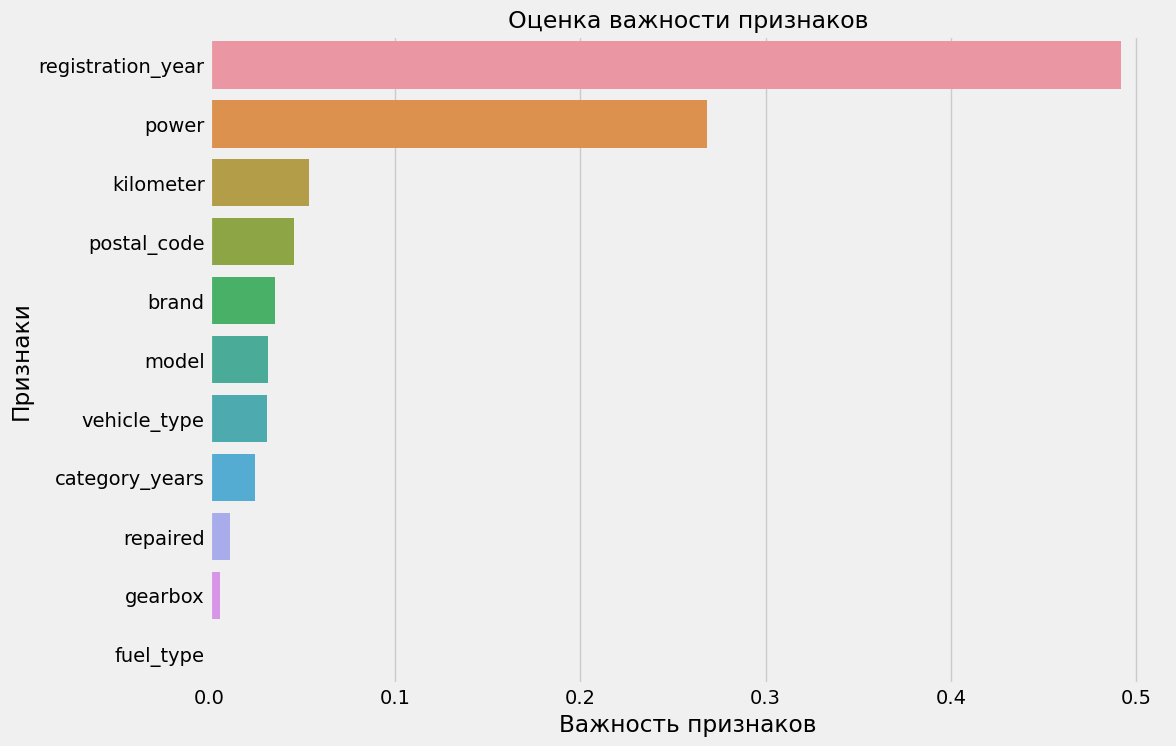

In [119]:
plt.figure(figsize=(11, 8))
sns.barplot(x=X_imp_RF['feature_importance'], y=X_imp_RF.index, order=X_imp_RF\
                .sort_values('feature_importance', ascending=False).index)
plt.title('Оценка важности признаков', fontsize=17)
plt.xlabel('Важность признаков')
plt.ylabel('Признаки');

### CatBoost

In [120]:
%%time
model_CB = CatBoostRegressor(random_state=RANDOM_STATE,
                               depth=16,
                               learning_rate=0.1,
                               iterations=400,
                               cat_features=categ)
model_CB.fit(X_train, y_train, verbose=False)

Wall time: 27min 24s


In [121]:
%%time
pred_CB_val = model_CB.predict(X_val)
print(f'Лучший показатель RMSE: {rmse(y_val, pred_CB_val):.6f}')

Лучший показатель RMSE: 1569.682394
Wall time: 1.53 s


In [134]:
res_CB = [' CatBoost', '27min 24s', '807 ms', 1569.682394]

In [123]:
%%time
X_imp_CB = pd.DataFrame({'features':X_train_ordinal.columns,'feature_importance':model_CB.feature_importances_})
X_imp_CB = X_imp_CB.set_index('features')
X_imp_CB.sort_values('feature_importance',ascending=False)

Wall time: 6 ms


,feature_importance
features,
registration_year,20.033817
power,17.154099
brand,15.862517
kilometer,10.078274
vehicle_type,10.042428
category_years,8.360508
model,7.442409
postal_code,4.443671
gearbox,2.676012


Wall time: 228 ms


Text(0, 0.5, 'Признаки')

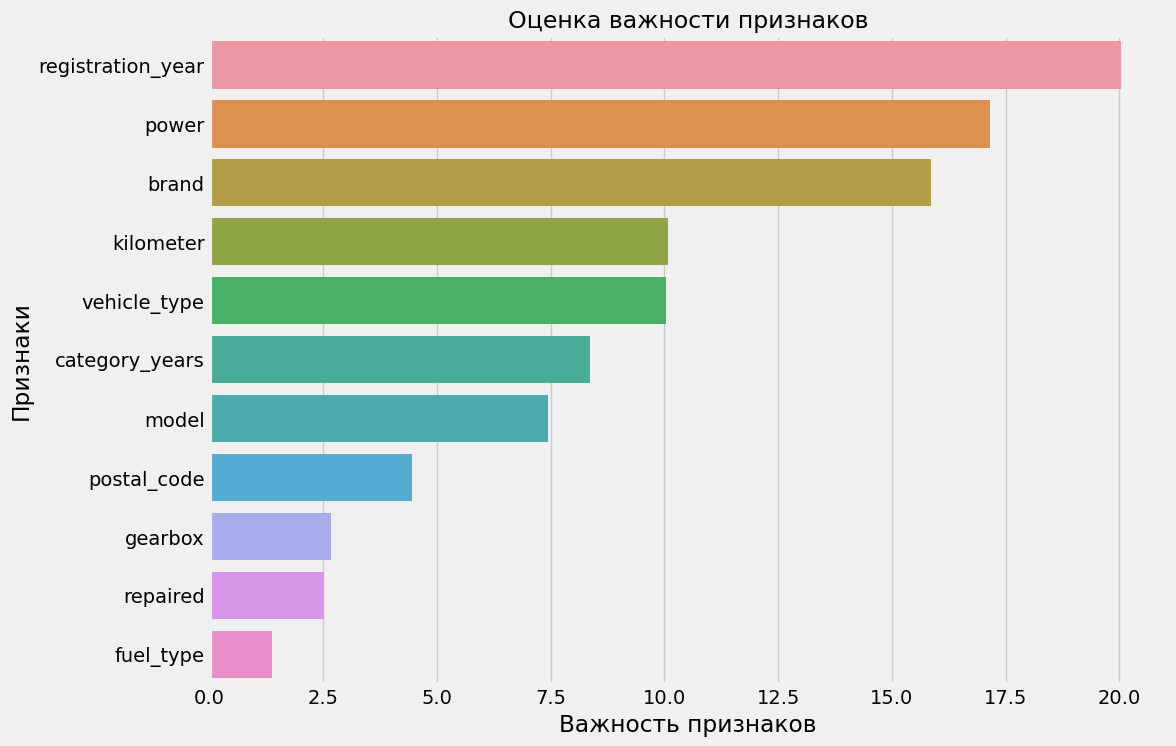

In [124]:
%%time
plt.figure(figsize=(11, 8))
sns.barplot(x=X_imp_CB['feature_importance'], y=X_imp_CB.index, order=X_imp_CB\
                .sort_values('feature_importance', ascending=False).index)
plt.title('Оценка важности признаков', fontsize=17)
plt.xlabel('Важность признаков')
plt.ylabel('Признаки');

### LightGBM

In [125]:
%%time
model_LGBM = LGBMRegressor(random_state=RANDOM_STATE,
                           max_depth=20,
                           num_leaves=350,
                           n_estimators=260,
                           n_jobs=-1)
model_LGBM.fit(X_train, y_train)

Wall time: 7.76 s


LGBMRegressor(max_depth=20, n_estimators=260, num_leaves=350, random_state=123)

In [126]:
%%time
pred_LGBM_val = model_LGBM.predict(X_val)
print(f'Лучший показатель RMSE: {rmse(y_val, pred_LGBM_val):.6f}')

Лучший показатель RMSE: 1533.573215
Wall time: 1.97 s


In [135]:
res_LGBM = ['LightGBM', '19.3 s', '1.51 s', 1533.573215]

In [128]:
X_imp_LGBM = pd.DataFrame({'features':X_train_ordinal.columns,'feature_importance':model_LGBM.feature_importances_})
X_imp_LGBM = X_imp_LGBM.set_index('features')
X_imp_LGBM.sort_values('feature_importance',ascending=False)

,feature_importance
features,
postal_code,27954
power,21070
registration_year,17439
kilometer,8698
model,6603
brand,2870
vehicle_type,2521
gearbox,1912
repaired,1213


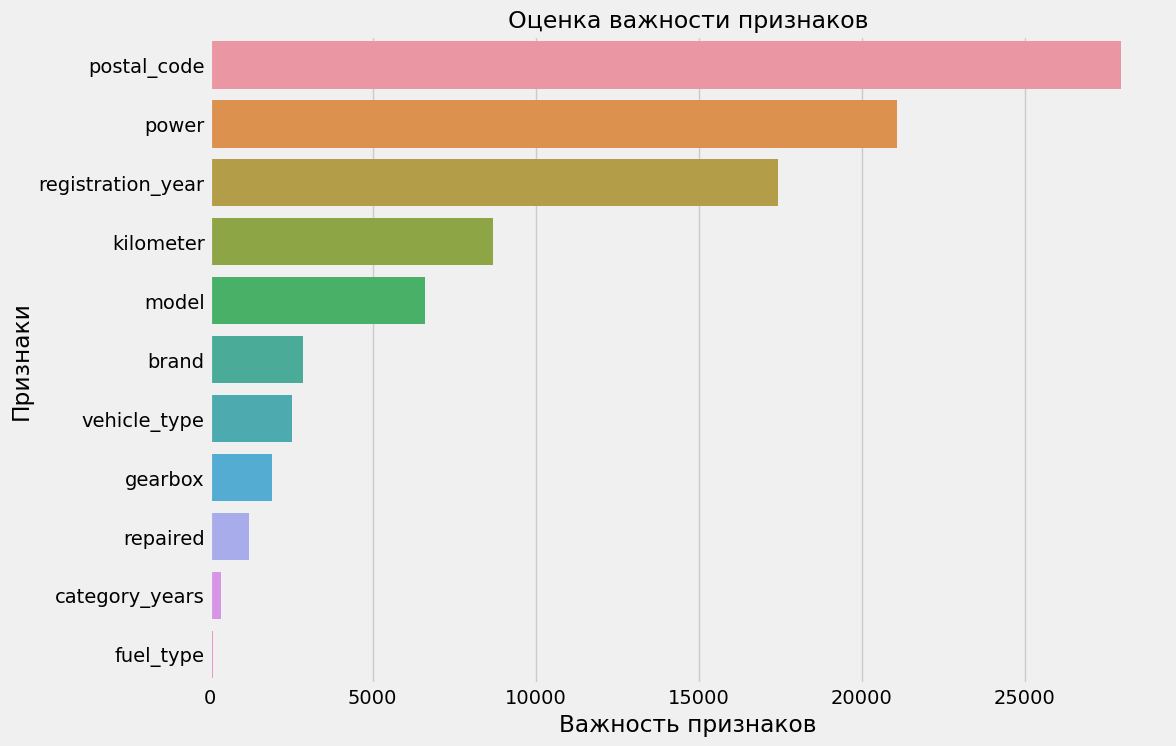

In [129]:
plt.figure(figsize=(11, 8))
sns.barplot(x=X_imp_LGBM['feature_importance'], y=X_imp_LGBM.index, order=X_imp_LGBM\
                .sort_values('feature_importance', ascending=False).index)
plt.title('Оценка важности признаков', fontsize=17)
plt.xlabel('Важность признаков')
plt.ylabel('Признаки');

**Посмотрим на результаты.**

In [136]:
res_tab = [res_LR, res_EN, res_DT, res_RF, res_CB, res_LGBM]
colum = ['Модель', 'Время обучения', 'Время предсказания', 'RMSE']
res_df = pd.DataFrame(res_tab,  columns=colum)
res_df = res_df.set_index('Модель')
res_df

,Время обучения,Время предсказания,RMSE
Модель,,,
Линейная регрессия,2.54 s,137 ms,2569.064936
ElasticNet,58.8 s,116 ms,2568.965994
Дерево решений,799 ms,14.6 ms,1924.850968
Случайный лес,1min 55s,3.54 s,1613.587356
CatBoost,27min 24s,807 ms,1569.682394
LightGBM,19.3 s,1.51 s,1533.573215


### Проверим лучшую модель на тестовой выборке

In [131]:
%%time
pred_LGBM_test = model_LGBM.predict(X_test)
print(f'Лучший показатель RMSE: {rmse(y_test, pred_LGBM_test):.6f}')

Лучший показатель RMSE: 1546.773335
Wall time: 2.43 s


###  Константная модель

In [132]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
pred_test_dummy = dummy_regr.predict(X_test)
print(f'Лучший показатель RMSE: {rmse(y_test, pred_test_dummy):.6f}')

Лучший показатель RMSE: 4539.274087


**Нашу модель можно считать адекватной. Показатели нашей модели значительно ниже константной модели.**

**Вывод:**     
+ мы проверили модели на валидационной выборке с подобранными гиперпараметрами     
+ построили таблицу результатов     
+ проверили лучшую модель на тестовой выборке     
+ проверили модель на вменяемость   

## Общий вывод:

**При подготовке данных:**  
+ привели названия колонок в snake-case.      
+ заполнили пропуски.
+ в некоторых колонках изменили тип
+ удалили дубликаты.     
+ оьработали аномальные значения        
+ удалили неинформативные колонки.

**Во втором пункте выяснили:**  

Мы обучили и подобрали гиперпараметры для шести моделей:     
+ линейную классическую   
+ линейную с комбинацией L1 и L2 регуляризации
+ модель деревьев    
+ ансамбль деревьев     
+ две модели градиентного бустинга

**На третьем этапе:**   

+ мы проверили модели на валидационной выборке с подобранными гиперпараметрами     
+ построили таблицу результатов     
+ проверили лучшую модель на тестовой выборке     
+ проверили модель на вменяемость   

**Мы построили модель, которая умеет определять рыночную стоимость автомобиля. И выбрали лучшую, исходя из пожеланий заказчика:**    

- качество предсказания;
- скорость предсказания;
- время обучения.